Training a neural net to label images as faces or not faces
----
Clément Domps
Yidi Zhu
MoSIG GVR

In [2]:
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import cv2 as cv2
import glob
import numpy as np

In [3]:
SIZE = (24,24)
#function to load the positive images
#we tried using the images in black & white but we got worse results than with colors
#we therefore keep them in RGB
def load_train_data(size=(24,24)):
    filenames = [img for img in glob.glob("./positive/*.jpg")]
    filenames.sort()
    images_pos = []
    for img in filenames:
        n = cv2.imread(img)
        n = cv2.resize(n, size)
        #n = cv2.cvtColor(n, cv2.COLOR_BGR2GRAY)
        images_pos.append(n)
    filenames = [img for img in glob.glob("./negative/*.jpg")]
    filenames.sort()
    images_neg = []
    for img in filenames:
        n = cv2.imread(img)
        n = cv2.resize(n, size)
        #n = cv2.cvtColor(n, cv2.COLOR_BGR2GRAY)
        images_neg.append(n)
    positives = np.array(images_pos)
    negatives = np.array(images_neg)
    x_train = np.concatenate((positives,negatives),axis=0)
    y_train = np.concatenate(([1 for k in range(positives.shape[0])],[0 for k in range(negatives.shape[0])]),axis=0)
    y_train = tf.keras.utils.to_categorical(y_train)
    return(x_train,y_train)

x_train, y_train = load_train_data(SIZE)

In [4]:
print(x_train.shape)
print(y_train.shape)

(7368, 24, 24, 3)
(7368, 2)


We have 7368 training samples consisting of about 4000 positives and 3000 negatives.

In [5]:
#split the data between the training and validation sets.
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(x_train,y_train,test_size=0.1)
print(train_x.shape)
print(train_y.shape)
print(val_y.shape)
print(val_x.shape)

(6631, 24, 24, 3)
(6631, 2)
(737, 2)
(737, 24, 24, 3)


In [6]:
#function to load the testing data
def load_test_data(size=(24,24)):
    filenames = [img for img in glob.glob("./TESTSET/face/*.jpg")]
    filenames.sort()
    images_pos = []
    for img in filenames:
        n = cv2.imread(img)
        n = cv2.resize(n, size)
        #n = cv2.cvtColor(n, cv2.COLOR_BGR2GRAY)
        images_pos.append(n)
    filenames = [img for img in glob.glob("./TESTSET/background/*.jpg")]
    filenames.sort()
    images_neg = []
    for img in filenames:
        n = cv2.imread(img)
        n = cv2.resize(n, size)
        #n = cv2.cvtColor(n, cv2.COLOR_BGR2GRAY)
        images_neg.append(n)
    positives = np.array(images_pos)
    negatives = np.array(images_neg)
    x_test = np.concatenate((positives,negatives),axis=0)
    y_test = np.concatenate(([1 for k in range(positives.shape[0])],[0 for k in range(negatives.shape[0])]),axis=0)
    y_test = tf.keras.utils.to_categorical(y_test)
    return(x_test,y_test)

x_test,y_test = load_test_data(SIZE)

In [7]:
# a few useful callbacks and training image generator
from keras.callbacks import Callback, ReduceLROnPlateau

#data generator for the training set
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    horizontal_flip=True,
)

# neural networks can benefits from a lower learning rate once training stagnate
# this will lower the LR if for 20 epochs, the validation loss did not lower.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor = "val_loss",
            factor=np.sqrt(0.1),
            patience=20,
            min_lr=0.5e-6,
            verbose=1)

# this callback saves the best weights during the training
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='model.hdf5', monitor='val_accuracy',verbose=1, save_weights_only=False,save_best_only=True)

In [8]:
model = keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(24, 24, 3)),
    tf.keras.layers.Dense(24*24*3,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(2,activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1728)              0         
_________________________________________________________________
dense (Dense)                (None, 1728)              2987712   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               221312    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 3,209,282
Trainable params: 3,209,282
Non-trainable params: 0
_________________________________________________________________


Training is performed on a GTX1660Ti.

In [9]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',"AUC"])

history = model.fit(datagen.flow(train_x, train_y,batch_size=512),
                              validation_data=(val_x,val_y),
                              epochs = 200,
                              callbacks=[reduce_lr,checkpointer])


Epoch 1/200
13/13 [==============================] - ETA: 0s - loss: 274.5888 - accuracy: 0.5589 - auc: 0.5590
Epoch 00001: val_accuracy improved from -inf to 0.44233, saving model to model.hdf5
13/13 [==============================] - 2s 177ms/step - loss: 274.5888 - accuracy: 0.5589 - auc: 0.5590 - val_loss: 143.1209 - val_accuracy: 0.4423 - val_auc: 0.4390
Epoch 2/200
13/13 [==============================] - ETA: 0s - loss: 71.2466 - accuracy: 0.6503 - auc: 0.6510
Epoch 00002: val_accuracy improved from 0.44233 to 0.68250, saving model to model.hdf5
13/13 [==============================] - 2s 157ms/step - loss: 71.2466 - accuracy: 0.6503 - auc: 0.6510 - val_loss: 59.3022 - val_accuracy: 0.6825 - val_auc: 0.6859
Epoch 3/200
13/13 [==============================] - ETA: 0s - loss: 42.7903 - accuracy: 0.7387 - auc: 0.7427
Epoch 00003: val_accuracy improved from 0.68250 to 0.79240, saving model to model.hdf5
13/13 [==============================] - 2s 184ms/step - loss: 42.7903 - accura

Epoch 26/200
13/13 [==============================] - ETA: 0s - loss: 2.7885 - accuracy: 0.8573 - auc: 0.8788
Epoch 00026: val_accuracy improved from 0.88738 to 0.90366, saving model to model.hdf5
13/13 [==============================] - 2s 156ms/step - loss: 2.7885 - accuracy: 0.8573 - auc: 0.8788 - val_loss: 1.5663 - val_accuracy: 0.9037 - val_auc: 0.9173
Epoch 27/200
13/13 [==============================] - ETA: 0s - loss: 5.1130 - accuracy: 0.7952 - auc: 0.8107
Epoch 00027: val_accuracy did not improve from 0.90366
13/13 [==============================] - 2s 148ms/step - loss: 5.1130 - accuracy: 0.7952 - auc: 0.8107 - val_loss: 2.3652 - val_accuracy: 0.8820 - val_auc: 0.9061
Epoch 28/200
13/13 [==============================] - ETA: 0s - loss: 3.4080 - accuracy: 0.8459 - auc: 0.8676
Epoch 00028: val_accuracy did not improve from 0.90366
13/13 [==============================] - 2s 155ms/step - loss: 3.4080 - accuracy: 0.8459 - auc: 0.8676 - val_loss: 2.7713 - val_accuracy: 0.8738 - 

Epoch 51/200
13/13 [==============================] - ETA: 0s - loss: 1.6339 - accuracy: 0.8489 - auc: 0.8844
Epoch 00051: val_accuracy did not improve from 0.90366
13/13 [==============================] - 2s 147ms/step - loss: 1.6339 - accuracy: 0.8489 - auc: 0.8844 - val_loss: 1.5664 - val_accuracy: 0.8562 - val_auc: 0.8864
Epoch 52/200
13/13 [==============================] - ETA: 0s - loss: 1.3153 - accuracy: 0.8807 - auc: 0.9117
Epoch 00052: val_accuracy did not improve from 0.90366
13/13 [==============================] - 2s 161ms/step - loss: 1.3153 - accuracy: 0.8807 - auc: 0.9117 - val_loss: 1.2101 - val_accuracy: 0.8643 - val_auc: 0.9068
Epoch 53/200
13/13 [==============================] - ETA: 0s - loss: 1.4499 - accuracy: 0.8607 - auc: 0.8949
Epoch 00053: val_accuracy did not improve from 0.90366
13/13 [==============================] - 2s 156ms/step - loss: 1.4499 - accuracy: 0.8607 - auc: 0.8949 - val_loss: 1.9270 - val_accuracy: 0.8521 - val_auc: 0.8914
Epoch 54/200
13/

Epoch 76/200
13/13 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.8994 - auc: 0.9372
Epoch 00076: val_accuracy did not improve from 0.90366
13/13 [==============================] - 2s 162ms/step - loss: 0.6941 - accuracy: 0.8994 - auc: 0.9372 - val_loss: 0.5808 - val_accuracy: 0.9009 - val_auc: 0.9433
Epoch 77/200
13/13 [==============================] - ETA: 0s - loss: 0.5740 - accuracy: 0.9030 - auc: 0.9441
Epoch 00077: val_accuracy did not improve from 0.90366
13/13 [==============================] - 2s 152ms/step - loss: 0.5740 - accuracy: 0.9030 - auc: 0.9441 - val_loss: 0.5095 - val_accuracy: 0.8955 - val_auc: 0.9511
Epoch 78/200
13/13 [==============================] - ETA: 0s - loss: 0.6798 - accuracy: 0.8824 - auc: 0.9296
Epoch 00078: val_accuracy did not improve from 0.90366
13/13 [==============================] - 2s 156ms/step - loss: 0.6798 - accuracy: 0.8824 - auc: 0.9296 - val_loss: 0.8225 - val_accuracy: 0.8833 - val_auc: 0.9227
Epoch 79/200
13/

Epoch 101/200
13/13 [==============================] - ETA: 0s - loss: 0.3201 - accuracy: 0.9047 - auc: 0.9604
Epoch 00101: val_accuracy did not improve from 0.91452
13/13 [==============================] - 2s 152ms/step - loss: 0.3201 - accuracy: 0.9047 - auc: 0.9604 - val_loss: 0.3019 - val_accuracy: 0.9023 - val_auc: 0.9598
Epoch 102/200
13/13 [==============================] - ETA: 0s - loss: 0.2984 - accuracy: 0.9076 - auc: 0.9628
Epoch 00102: val_accuracy did not improve from 0.91452
13/13 [==============================] - 2s 147ms/step - loss: 0.2984 - accuracy: 0.9076 - auc: 0.9628 - val_loss: 0.7381 - val_accuracy: 0.8209 - val_auc: 0.9015
Epoch 103/200
13/13 [==============================] - ETA: 0s - loss: 0.4837 - accuracy: 0.8804 - auc: 0.9380
Epoch 00103: val_accuracy did not improve from 0.91452
13/13 [==============================] - 2s 142ms/step - loss: 0.4837 - accuracy: 0.8804 - auc: 0.9380 - val_loss: 0.4177 - val_accuracy: 0.8996 - val_auc: 0.9474
Epoch 104/200

Epoch 126/200
13/13 [==============================] - ETA: 0s - loss: 0.2144 - accuracy: 0.9216 - auc: 0.9748
Epoch 00126: val_accuracy did not improve from 0.91452
13/13 [==============================] - 2s 155ms/step - loss: 0.2144 - accuracy: 0.9216 - auc: 0.9748 - val_loss: 0.3440 - val_accuracy: 0.8915 - val_auc: 0.9540
Epoch 127/200
13/13 [==============================] - ETA: 0s - loss: 0.2177 - accuracy: 0.9169 - auc: 0.9737
Epoch 00127: val_accuracy did not improve from 0.91452
13/13 [==============================] - 2s 145ms/step - loss: 0.2177 - accuracy: 0.9169 - auc: 0.9737 - val_loss: 0.2458 - val_accuracy: 0.9009 - val_auc: 0.9692
Epoch 128/200
13/13 [==============================] - ETA: 0s - loss: 0.2404 - accuracy: 0.9139 - auc: 0.9705
Epoch 00128: val_accuracy did not improve from 0.91452
13/13 [==============================] - 2s 156ms/step - loss: 0.2404 - accuracy: 0.9139 - auc: 0.9705 - val_loss: 0.3370 - val_accuracy: 0.8820 - val_auc: 0.9531
Epoch 129/200

Epoch 151/200
13/13 [==============================] - ETA: 0s - loss: 0.1613 - accuracy: 0.9374 - auc: 0.9838
Epoch 00151: val_accuracy did not improve from 0.91859
13/13 [==============================] - 2s 162ms/step - loss: 0.1613 - accuracy: 0.9374 - auc: 0.9838 - val_loss: 0.2297 - val_accuracy: 0.9172 - val_auc: 0.9726
Epoch 152/200
13/13 [==============================] - ETA: 0s - loss: 0.1696 - accuracy: 0.9347 - auc: 0.9822
Epoch 00152: val_accuracy did not improve from 0.91859
13/13 [==============================] - 2s 163ms/step - loss: 0.1696 - accuracy: 0.9347 - auc: 0.9822 - val_loss: 0.2633 - val_accuracy: 0.9064 - val_auc: 0.9657
Epoch 153/200
13/13 [==============================] - ETA: 0s - loss: 0.1681 - accuracy: 0.9332 - auc: 0.9829
Epoch 00153: val_accuracy did not improve from 0.91859
13/13 [==============================] - 2s 156ms/step - loss: 0.1681 - accuracy: 0.9332 - auc: 0.9829 - val_loss: 0.2468 - val_accuracy: 0.9118 - val_auc: 0.9693
Epoch 154/200

Epoch 176/200
13/13 [==============================] - ETA: 0s - loss: 0.1493 - accuracy: 0.9416 - auc: 0.9859
Epoch 00176: val_accuracy did not improve from 0.91859
13/13 [==============================] - 2s 153ms/step - loss: 0.1493 - accuracy: 0.9416 - auc: 0.9859 - val_loss: 0.2372 - val_accuracy: 0.9132 - val_auc: 0.9722
Epoch 177/200
13/13 [==============================] - ETA: 0s - loss: 0.1524 - accuracy: 0.9410 - auc: 0.9856
Epoch 00177: val_accuracy did not improve from 0.91859
13/13 [==============================] - 2s 156ms/step - loss: 0.1524 - accuracy: 0.9410 - auc: 0.9856 - val_loss: 0.2385 - val_accuracy: 0.9145 - val_auc: 0.9712
Epoch 178/200
13/13 [==============================] - ETA: 0s - loss: 0.1547 - accuracy: 0.9397 - auc: 0.9849
Epoch 00178: val_accuracy did not improve from 0.91859
13/13 [==============================] - 2s 152ms/step - loss: 0.1547 - accuracy: 0.9397 - auc: 0.9849 - val_loss: 0.2407 - val_accuracy: 0.9145 - val_auc: 0.9717
Epoch 179/200

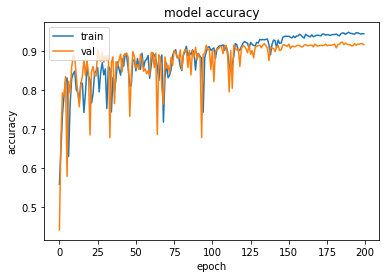

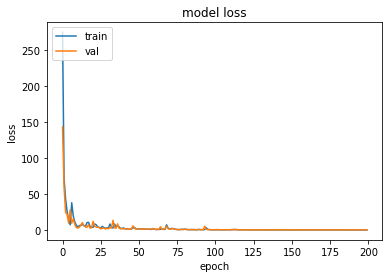

In [10]:
def plot_history(history):
    """
    plot l'accuracy et la loss
    """
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
plot_history(history)

In [11]:
model.load_weights("model.hdf5")

In [12]:
res = model.evaluate(x_test,y_test)

65/65 [==============================] - 0s 3ms/step - loss: 0.1927 - accuracy: 0.9406 - auc: 0.9801


In [13]:
y = np.argmax(y_test,axis=1)

In [14]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
y_pred = np.argmax(model.predict(x_test),axis=1)
print("accuracy is "+str(res[1]))
print("f1 is "+str(f1_score(y,y_pred)))
print("recall is "+str(recall_score(y,y_pred)))
print("precision is "+str(precision_score(y,y_pred)))
print("AUC is "+str(res[2]))

accuracy is 0.9405797123908997
f1 is 0.9417889256980597
recall is 0.961352657004831
precision is 0.9230055658627088
AUC is 0.9800556898117065


In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test.argmax(axis=1), model.predict(x_test).argmax(axis=1))

array([[952,  83],
       [ 40, 995]], dtype=int64)

With the confusion matrix, we can see that our model is a bit biased towards detecting faces.
We should be able to squeeze a bit more performance by using the test set as a validation set.
let's check that below

In [16]:
model = keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(24, 24, 3)),
    tf.keras.layers.Dense(24*24*3,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(2,activation='softmax')
])
model.summary()

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',"AUC"])

history = model.fit(datagen.flow(x_train, y_train,batch_size=512),
                              validation_data=(x_test,y_test),
                              epochs = 200,
                              callbacks=[reduce_lr,checkpointer])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1728)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1728)              2987712   
_________________________________________________________________
dense_4 (Dense)              (None, 128)               221312    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
Total params: 3,209,282
Trainable params: 3,209,282
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
15/15 [==============================] - ETA: 0s - loss: 238.0804 - accuracy: 0.5517 - auc: 0.5529
Epoch 00001: val_accuracy did not improve from 0.92266
15/15 [==============================] - 2s 164ms/step - loss: 238.0804 - ac

15/15 [==============================] - ETA: 0s - loss: 1.9923 - accuracy: 0.7788 - auc: 0.8231
Epoch 00048: val_accuracy did not improve from 0.92266
15/15 [==============================] - 2s 165ms/step - loss: 1.9923 - accuracy: 0.7788 - auc: 0.8231 - val_loss: 0.8575 - val_accuracy: 0.8807 - val_auc: 0.9246
Epoch 49/200
15/15 [==============================] - ETA: 0s - loss: 1.0847 - accuracy: 0.8479 - auc: 0.8960
Epoch 00049: val_accuracy did not improve from 0.92266
15/15 [==============================] - 2s 160ms/step - loss: 1.0847 - accuracy: 0.8479 - auc: 0.8960 - val_loss: 1.2470 - val_accuracy: 0.8005 - val_auc: 0.8623
Epoch 50/200
15/15 [==============================] - ETA: 0s - loss: 0.8943 - accuracy: 0.8578 - auc: 0.9091
Epoch 00050: val_accuracy did not improve from 0.92266
15/15 [==============================] - 2s 164ms/step - loss: 0.8943 - accuracy: 0.8578 - auc: 0.9091 - val_loss: 1.0674 - val_accuracy: 0.8464 - val_auc: 0.8983
Epoch 51/200
15/15 [=========

Epoch 73/200
15/15 [==============================] - ETA: 0s - loss: 0.4219 - accuracy: 0.9016 - auc: 0.9509
Epoch 00073: val_accuracy did not improve from 0.93671
15/15 [==============================] - 2s 153ms/step - loss: 0.4219 - accuracy: 0.9016 - auc: 0.9509 - val_loss: 0.3734 - val_accuracy: 0.9150 - val_auc: 0.9604
Epoch 74/200
15/15 [==============================] - ETA: 0s - loss: 0.3613 - accuracy: 0.9019 - auc: 0.9577
Epoch 00074: val_accuracy did not improve from 0.93671
15/15 [==============================] - 2s 156ms/step - loss: 0.3613 - accuracy: 0.9019 - auc: 0.9577 - val_loss: 0.3006 - val_accuracy: 0.9227 - val_auc: 0.9694
Epoch 75/200
15/15 [==============================] - ETA: 0s - loss: 0.3279 - accuracy: 0.9051 - auc: 0.9604
Epoch 00075: val_accuracy did not improve from 0.93671
15/15 [==============================] - 3s 170ms/step - loss: 0.3279 - accuracy: 0.9051 - auc: 0.9604 - val_loss: 0.3105 - val_accuracy: 0.9222 - val_auc: 0.9678
Epoch 76/200
15/

Epoch 98/200
15/15 [==============================] - ETA: 0s - loss: 0.3316 - accuracy: 0.9115 - auc: 0.9615
Epoch 00098: val_accuracy did not improve from 0.93671
15/15 [==============================] - 2s 158ms/step - loss: 0.3316 - accuracy: 0.9115 - auc: 0.9615 - val_loss: 0.3550 - val_accuracy: 0.9121 - val_auc: 0.9593
Epoch 99/200
15/15 [==============================] - ETA: 0s - loss: 0.3304 - accuracy: 0.8990 - auc: 0.9587
Epoch 00099: val_accuracy did not improve from 0.93671
15/15 [==============================] - 2s 164ms/step - loss: 0.3304 - accuracy: 0.8990 - auc: 0.9587 - val_loss: 0.4599 - val_accuracy: 0.8923 - val_auc: 0.9466
Epoch 100/200
15/15 [==============================] - ETA: 0s - loss: 0.4244 - accuracy: 0.8928 - auc: 0.9486
Epoch 00100: val_accuracy did not improve from 0.93671
15/15 [==============================] - 2s 159ms/step - loss: 0.4244 - accuracy: 0.8928 - auc: 0.9486 - val_loss: 0.2623 - val_accuracy: 0.9295 - val_auc: 0.9751
Epoch 101/200
1

Epoch 123/200
15/15 [==============================] - ETA: 0s - loss: 0.2804 - accuracy: 0.9085 - auc: 0.9656
Epoch 00123: val_accuracy did not improve from 0.94106
15/15 [==============================] - 2s 163ms/step - loss: 0.2804 - accuracy: 0.9085 - auc: 0.9656 - val_loss: 0.3170 - val_accuracy: 0.9097 - val_auc: 0.9658
Epoch 124/200
15/15 [==============================] - ETA: 0s - loss: 0.2144 - accuracy: 0.9236 - auc: 0.9760
Epoch 00124: val_accuracy did not improve from 0.94106
15/15 [==============================] - 2s 156ms/step - loss: 0.2144 - accuracy: 0.9236 - auc: 0.9760 - val_loss: 0.2767 - val_accuracy: 0.9179 - val_auc: 0.9707
Epoch 125/200
15/15 [==============================] - ETA: 0s - loss: 0.2095 - accuracy: 0.9240 - auc: 0.9769
Epoch 00125: val_accuracy did not improve from 0.94106
15/15 [==============================] - 2s 163ms/step - loss: 0.2095 - accuracy: 0.9240 - auc: 0.9769 - val_loss: 0.2945 - val_accuracy: 0.9145 - val_auc: 0.9670
Epoch 126/200

Epoch 148/200
15/15 [==============================] - ETA: 0s - loss: 0.2249 - accuracy: 0.9190 - auc: 0.9736
Epoch 00148: val_accuracy improved from 0.94106 to 0.94396, saving model to model.hdf5
15/15 [==============================] - 3s 167ms/step - loss: 0.2249 - accuracy: 0.9190 - auc: 0.9736 - val_loss: 0.2077 - val_accuracy: 0.9440 - val_auc: 0.9805
Epoch 149/200
15/15 [==============================] - ETA: 0s - loss: 0.1867 - accuracy: 0.9330 - auc: 0.9803
Epoch 00149: val_accuracy did not improve from 0.94396
15/15 [==============================] - 2s 153ms/step - loss: 0.1867 - accuracy: 0.9330 - auc: 0.9803 - val_loss: 0.2129 - val_accuracy: 0.9401 - val_auc: 0.9786
Epoch 150/200
15/15 [==============================] - ETA: 0s - loss: 0.1827 - accuracy: 0.9313 - auc: 0.9801
Epoch 00150: val_accuracy did not improve from 0.94396
15/15 [==============================] - 2s 157ms/step - loss: 0.1827 - accuracy: 0.9313 - auc: 0.9801 - val_loss: 0.2099 - val_accuracy: 0.9401

Epoch 173/200
15/15 [==============================] - ETA: 0s - loss: 0.1743 - accuracy: 0.9344 - auc: 0.9815
Epoch 00173: val_accuracy did not improve from 0.94396
15/15 [==============================] - 2s 151ms/step - loss: 0.1743 - accuracy: 0.9344 - auc: 0.9815 - val_loss: 0.2443 - val_accuracy: 0.9222 - val_auc: 0.9736
Epoch 174/200
15/15 [==============================] - ETA: 0s - loss: 0.1704 - accuracy: 0.9342 - auc: 0.9823
Epoch 00174: val_accuracy did not improve from 0.94396
15/15 [==============================] - 2s 154ms/step - loss: 0.1704 - accuracy: 0.9342 - auc: 0.9823 - val_loss: 0.1958 - val_accuracy: 0.9401 - val_auc: 0.9823
Epoch 175/200
15/15 [==============================] - ETA: 0s - loss: 0.1803 - accuracy: 0.9342 - auc: 0.9804
Epoch 00175: val_accuracy did not improve from 0.94396
15/15 [==============================] - 2s 160ms/step - loss: 0.1803 - accuracy: 0.9342 - auc: 0.9804 - val_loss: 0.2497 - val_accuracy: 0.9198 - val_auc: 0.9724
Epoch 176/200

Epoch 198/200
15/15 [==============================] - ETA: 0s - loss: 0.2292 - accuracy: 0.9198 - auc: 0.9727
Epoch 00198: val_accuracy did not improve from 0.94396
15/15 [==============================] - 2s 167ms/step - loss: 0.2292 - accuracy: 0.9198 - auc: 0.9727 - val_loss: 0.2006 - val_accuracy: 0.9382 - val_auc: 0.9820
Epoch 199/200
15/15 [==============================] - ETA: 0s - loss: 0.2219 - accuracy: 0.9188 - auc: 0.9738
Epoch 00199: val_accuracy did not improve from 0.94396
15/15 [==============================] - 2s 159ms/step - loss: 0.2219 - accuracy: 0.9188 - auc: 0.9738 - val_loss: 0.3501 - val_accuracy: 0.8952 - val_auc: 0.9554
Epoch 200/200
15/15 [==============================] - ETA: 0s - loss: 0.2209 - accuracy: 0.9226 - auc: 0.9738
Epoch 00200: val_accuracy did not improve from 0.94396
15/15 [==============================] - 2s 166ms/step - loss: 0.2209 - accuracy: 0.9226 - auc: 0.9738 - val_loss: 0.2072 - val_accuracy: 0.9362 - val_auc: 0.9808


In [17]:
model.load_weights("model.hdf5")
res = model.evaluate(x_test,y_test)
y_pred = np.argmax(model.predict(x_test),axis=1)
print("accuracy is "+str(res[1]))
print("f1 is "+str(f1_score(y,y_pred)))
print("recall is "+str(recall_score(y,y_pred)))
print("precision is "+str(precision_score(y,y_pred)))
print("AUC is "+str(res[2]))

65/65 [==============================] - 0s 3ms/step - loss: 0.2077 - accuracy: 0.9440 - auc: 0.9805
accuracy is 0.9439613819122314
f1 is 0.9442307692307692
recall is 0.9487922705314009
precision is 0.939712918660287
AUC is 0.9804688096046448


We were in fact able to squeeze out a bit more accuracy but dependings on run it isn't always significant.

Impact of the size of the images
--
In this part, we'll try various sizes for the images to see if one is better than the others.

In [18]:
sizes = [(8,8),(16,16),(24,24),(32,32),(64,64)]
accuracy = []

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    horizontal_flip=True,
)

for size in sizes:  
    x_train, y_train = load_train_data(size)
    x_test,y_test = load_test_data(size)
    print("size "+str(size[0])+" "+str(size[1]))
    print(x_train.shape[1])
    model = keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(size[0], size[1], 3)),
    tf.keras.layers.Dense(size[0]*size[1]*3,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(2,activation='softmax')
    ])
    model.summary()

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

    history = model.fit(datagen.flow(x_train, y_train,batch_size=512),
                                  validation_data=(x_test,y_test),
                                  epochs = 50)
    accuracy.append(model.evaluate(x_test,y_test)[1])

print(accuracy)

size 8 8
8
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 192)               37056     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               24704     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 258       
Total params: 62,018
Trainable params: 62,018
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
15/15 [==============================] - 1s 100ms/step - loss: 25.3873 - accuracy: 0.6368 - val_loss: 9.9487 - val_accuracy: 0.6961
Epoch 2/50
15/15 [==============================] - 2s 104ms/step - loss: 6.1115 - accuracy: 0

Epoch 1/50
15/15 [==============================] - 2s 119ms/step - loss: 88.5310 - accuracy: 0.5775 - val_loss: 2.4521 - val_accuracy: 0.7213
Epoch 2/50
15/15 [==============================] - 2s 111ms/step - loss: 2.4715 - accuracy: 0.7151 - val_loss: 1.5824 - val_accuracy: 0.7928
Epoch 3/50
15/15 [==============================] - 2s 110ms/step - loss: 1.4219 - accuracy: 0.7694 - val_loss: 1.3782 - val_accuracy: 0.7787
Epoch 4/50
15/15 [==============================] - 2s 111ms/step - loss: 0.7834 - accuracy: 0.8107 - val_loss: 1.7993 - val_accuracy: 0.7237
Epoch 5/50
15/15 [==============================] - 2s 109ms/step - loss: 1.3806 - accuracy: 0.7571 - val_loss: 0.7654 - val_accuracy: 0.8348
Epoch 6/50
15/15 [==============================] - 2s 111ms/step - loss: 0.7752 - accuracy: 0.8268 - val_loss: 0.9473 - val_accuracy: 0.8048
Epoch 7/50
15/15 [==============================] - 2s 109ms/step - loss: 0.6221 - accuracy: 0.8426 - val_loss: 0.5224 - val_accuracy: 0.8546
Epoch

15/15 [==============================] - 3s 196ms/step - loss: 447.5464 - accuracy: 0.5571 - val_loss: 1.0412 - val_accuracy: 0.6913
Epoch 2/50
15/15 [==============================] - 3s 190ms/step - loss: 4.4815 - accuracy: 0.5946 - val_loss: 5.4536 - val_accuracy: 0.5435
Epoch 3/50
15/15 [==============================] - 3s 193ms/step - loss: 3.1202 - accuracy: 0.6730 - val_loss: 1.3606 - val_accuracy: 0.7870
Epoch 4/50
15/15 [==============================] - 3s 196ms/step - loss: 0.8862 - accuracy: 0.6600 - val_loss: 0.7140 - val_accuracy: 0.5000
Epoch 5/50
15/15 [==============================] - 3s 188ms/step - loss: 0.6858 - accuracy: 0.5613 - val_loss: 0.7105 - val_accuracy: 0.5000
Epoch 6/50
15/15 [==============================] - 3s 187ms/step - loss: 0.6695 - accuracy: 0.5613 - val_loss: 0.6733 - val_accuracy: 0.5000
Epoch 7/50
15/15 [==============================] - 3s 190ms/step - loss: 0.6283 - accuracy: 0.5613 - val_loss: 0.6461 - val_accuracy: 0.5000
Epoch 8/50
15/1

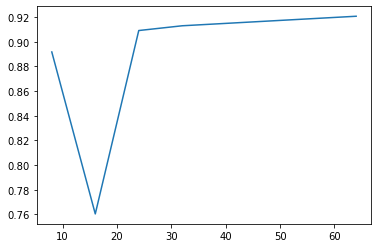

In [19]:
plt.plot([sizes[k][0] for k in range(len(sizes))],accuracy)

It appears that all sizes are good. We see a drop in performance for 16x16 but is just due to the variations between runs.